## Time Series Forecasting of Stock Prices with Attention based Hybrid model

In [1]:
# # code to mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('/kaggle/input/aapl-stock/AAPL.csv')

In [4]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [5]:
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [6]:
df1=df.reset_index()['close']

In [7]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

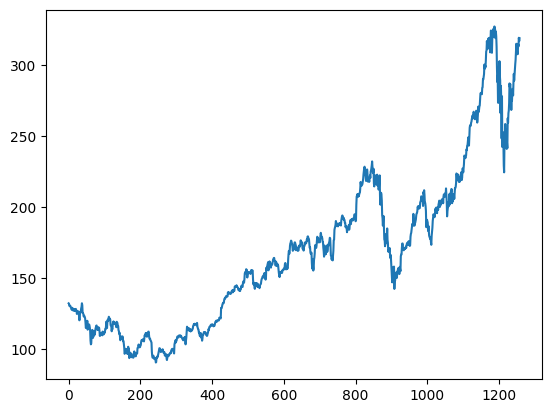

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [10]:
import numpy as np

In [11]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(817, 441)

In [16]:
print(train_data[:5])

[[0.17607447]
 [0.17495567]
 [0.16862282]
 [0.1696994 ]
 [0.16727181]]


In [17]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [20]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,GRU,Conv1D,MaxPooling1D,Flatten

In [23]:
# model=Sequential()
# model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
# model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
!pip install keras-tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Attention, Concatenate, Input
import kerastuner as kt
from sklearn.model_selection import KFold
import tensorflow as tf

/tmp/ipykernel_35/4040601191.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [26]:
# from tensorflow.keras.layers import Dropout

# class StockPriceHyperModel(kt.HyperModel):
#     def build(self, hp):
#         inputs = Input(shape=(time_step, 1))
        
#         # LSTM Layer with dropout
#         x = LSTM(
#             units=hp.Int('lstm_units', min_value=30, max_value=70, step=10),
#             return_sequences=True
#         )(inputs)
#         x = Dropout(hp.Float('lstm_dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
        
#         # GRU Layer with dropout
#         x = GRU(
#             units=hp.Int('gru_units', min_value=30, max_value=70, step=10),
#             return_sequences=True
#         )(x)
#         x = Dropout(hp.Float('gru_dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
        
#         # Attention Layer
#         attention_output = Attention()([x, x])
        
#         # Final LSTM Layer (with no return_sequences)
#         x = LSTM(units=hp.Int('final_lstm_units', min_value=20, max_value=50, step=10))(attention_output)
        
#         # Dense output layer
#         outputs = Dense(1)(x)
        
#         # Compile the model
#         model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
#         model.compile(
#             loss='mean_squared_error',
#             optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop'])
#         )
        
#         return model


In [27]:
!rm -r /kaggle/working/keras_tuner_dir


rm: cannot remove '/kaggle/working/keras_tuner_dir': No such file or directory


In [28]:
# import keras_tuner as kt
# import tensorflow as tf
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Input
# from tensorflow.keras.models import Model

# class StockPriceHyperModel(kt.HyperModel):
#     def build(self, hp):
#         inputs = Input(shape=(time_step, 1))
        
#         # CNN layers
#         x = Conv1D(
#             filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16),
#             kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1),
#             activation='relu'
#         )(inputs)
#         x = MaxPooling1D(pool_size=2)(x)
#         x = Flatten()(x)
        
#         # Reshape for LSTM input
#         x = tf.keras.layers.Reshape((x.shape[1], 1))(x)
        
#         # LSTM layers
#         x = LSTM(
#             units=hp.Int('lstm_units1', min_value=50, max_value=100, step=10),
#             return_sequences=True
#         )(x)
#         x = LSTM(
#             units=hp.Int('lstm_units2', min_value=50, max_value=100, step=10)
#         )(x)
        
#         # Output layer
#         outputs = Dense(1)(x)
        
#         model = Model(inputs=inputs, outputs=outputs)
#         model.compile(
#             loss='mean_squared_error',
#             optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop'])
#         )
        
#         return model

In [29]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Input, Attention, Reshape, Concatenate
from tensorflow.keras.models import Model

class StockPriceHyperModel(kt.HyperModel):
    def build(self, hp):
        inputs = Input(shape=(time_step, 1))
        
        # CNN layers
        x = Conv1D(
            filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16),
            kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1),
            activation='relu'
        )(inputs)
        x = MaxPooling1D(pool_size=2)(x)
        x = Flatten()(x)
        
        # Reshape for LSTM input
        x = Reshape((x.shape[1], 1))(x)
        
        # LSTM layers
        x_lstm = LSTM(
            units=hp.Int('lstm_units1', min_value=50, max_value=100, step=10),
            return_sequences=True
        )(x)
        x_lstm = LSTM(
            units=hp.Int('lstm_units2', min_value=50, max_value=100, step=10),
            return_sequences=True
        )(x_lstm)
        
        # Attention layer (showcasing)
        attention_output = Attention()([x_lstm, x_lstm])
        
        # Concatenate attention output with LSTM output
        combined = Concatenate(axis=-1)([x_lstm, attention_output])
        
        # Further LSTM layer on combined output
        x = LSTM(
            units=hp.Int('lstm_units3', min_value=50, max_value=100, step=10)
        )(combined)
        
        # Output layer
        outputs = Dense(1)(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(
            loss='mean_squared_error',
            optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop'])
        )
        
        return model


In [30]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import KFold
import keras_tuner as kt

# Initialize the tuner
tuner = kt.RandomSearch(
    StockPriceHyperModel(),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='stock_price_prediction'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform k-fold cross-validation with the tuner
def perform_kfold_cross_validation(X, y, n_splits=3, epochs=100):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    results = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        tuner.search(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])
        best_model = tuner.get_best_models(num_models=1)[0]
        val_loss = best_model.evaluate(X_val, y_val, verbose=0)
        results.append(val_loss)
        print(f'Fold {fold_no} - Validation Loss: {val_loss}')
        fold_no += 1

    avg_loss = np.mean(results)
    print(f'Average Validation Loss: {avg_loss}')
    
    return tuner

# Call the function and store the returned tuner object
tuner = perform_kfold_cross_validation(X_train, y_train, n_splits=3, epochs=10)

Trial 5 Complete [00h 00m 43s]
val_loss: 0.0002548054908402264

Best val_loss So Far: 0.0001677049440331757
Total elapsed time: 00h 04m 06s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 - Validation Loss: 0.0001677049440331757
Fold 2 - Validation Loss: 0.00017658087017480284
Fold 3 - Validation Loss: 0.00014205336628947407
Average Validation Loss: 0.00016211306016581753


In [33]:
# Train final model with best parameters from the last fold
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 4.4468e-04 - val_loss: 3.2008e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 1.5184e-04 - val_loss: 4.5109e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 1.1996e-04 - val_loss: 3.0428e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 9.8930e-05 - val_loss: 2.9438e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 1.1320e-04 - val_loss: 3.4984e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 1.1364e-04 - val_loss: 3.2151e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 1.0915e-04 - val_loss: 2.8736e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 9.9541e-05 - val_loss: 2.8761e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 1.2655e-04 - val_loss: 5.0674e-04


In [34]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 48)    │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 49, 48)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2352)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 2352, 1)   │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 2352, 90)  │     33,120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 2352, 100) │     76,400 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 2352, 100) │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2352, 200) │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 60)        │     62,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         61 │ lstm_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 517,241 (1.97 MB)

 Trainable params: 172,413 (673.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 344,828 (1.32 MB)

In [35]:
import tensorflow as tf

In [ ]:
tf.__version__

In [36]:
### Lets Do the prediction and check performance metrics
train_predict=best_model.predict(X_train)
test_predict=best_model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step


In [37]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [38]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

137.8698140034906

In [39]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

222.06044881345827

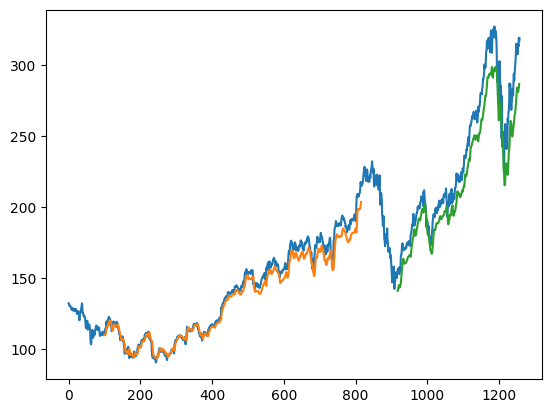

In [40]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

In [42]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [43]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [44]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [46]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = best_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = best_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

0 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.90095415 0.927932

In [47]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [48]:
import matplotlib.pyplot as plt

In [49]:
len(df1)

1258

In [54]:
# plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [55]:
# df3=df1.tolist()
# df3.extend(lst_output)
# plt.plot(df3[1200:])

In [52]:
# df3=scaler.inverse_transform(df3).tolist()

In [56]:
# plt.plot(df3)